# Recommending movies using SVD Matrix Factorisation

\- [Saurabh Mathur](saurabhmathur96.github.io)

The aim of this experiment is to recommend movies to a user by learning latent features of both movies and users.
To do so, I'll use the SVD Latent factor model for matrix factorization as discuessed by
[Yehuda Koren](http://www.cs.rochester.edu/twiki/pub/Main/HarpSeminar/Factorization_Meets_the_Neighborhood-_a_Multifaceted_Collaborative_Filtering_Model.pdf).

In [157]:
import tensorflow as tf

In [158]:
import pandas as pd

ratings = pd.read_csv("../data/intermediate/ratings.csv", index_col=0)

ratings.head()

,UserID,ContinuousUserID,MovieID,ContinuousMovieID,Rating
0,1,0,1,0,5
1,1,0,48,47,5
2,1,0,150,148,5
3,1,0,260,257,4
4,1,0,527,523,5


In [159]:
import pandas as pd

movies = pd.read_csv("../data/intermediate/movies.csv", index_col=0)

movies.head()

,MovieID,Title,Genres,ContinuousMovieID
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [160]:
import numpy as np

user_ids = np.array(ratings["ContinuousUserID"].tolist())
movie_ids = np.array(ratings["ContinuousMovieID"].tolist())
user_ratings = np.array(ratings["Rating"].tolist())

print (user_ratings.shape)

(1000209,)


## Building the model

Rating can be predicted as -

$$ prediction = user\_embedding[userid] \cdot movie\_embedding[movieid] + user\_bias[userid] + movie\_bias[movieid] + global\_bias $$

The objective is to minimize -

$$ || prediction - rating ||^2  + \lambda (||user\_embedding||^2 + ||movie\_embedding||^2 + ||user\_bias||^2 + ||movie\_bias||^2) $$

where $\lambda$ is the regularization hyperparameter

In [161]:
graph = tf.Graph()
n_movie = 3883
n_user = 6040
embedding_size = 20



lr = 0.001
reg = 0.001



with graph.as_default():
    user = tf.placeholder(tf.int32, name="user_id") 
    movie = tf.placeholder(tf.int32, name="movie_id") 
    rating = tf.placeholder(tf.float32, name="rating") 

    movie_embedding = tf.Variable(tf.truncated_normal([n_movie, embedding_size], stddev=0.02, mean=0.) ,name="movie_embedding")
    user_embedding = tf.Variable(tf.truncated_normal([n_user, embedding_size], stddev=0.02, mean=0.) ,name="user_embedding")
    
    movie_bias_embedding = tf.Variable(tf.truncated_normal([n_movie], stddev=0.02, mean=0.) ,name="movie_bias_embedding")
    user_bias_embedding = tf.Variable(tf.truncated_normal([n_user], stddev=0.02, mean=0.) ,name="user_bias_embedding")
    
    
    global_bias = tf.Variable(tf.truncated_normal([], stddev=0.02, mean=0.) ,name="global_bias")
    
    u = tf.nn.embedding_lookup(user_embedding, user)
    m = tf.nn.embedding_lookup(movie_embedding, movie)
    
    u_bias = tf.nn.embedding_lookup(user_bias_embedding, user)
    m_bias = tf.nn.embedding_lookup(movie_bias_embedding, movie)
    

    predicted_rating = tf.reduce_sum(tf.mul(u, m), 1) + u_bias + m_bias + global_bias

    rmse = tf.sqrt(tf.reduce_mean(tf.square(predicted_rating - rating))) # RMSE
    cost = tf.nn.l2_loss(predicted_rating - rating)
    regularization = reg * (tf.nn.l2_loss(movie_embedding) + tf.nn.l2_loss(user_embedding)
                            + tf.nn.l2_loss(movie_bias_embedding) + tf.nn.l2_loss(user_bias_embedding))
    
    loss = cost + regularization
    
    optimizer = tf.train.AdamOptimizer(lr).minimize(loss)
    
    

In [162]:
batch_size = 1000
n_epoch = 10


with tf.Session(graph=graph) as sess:
    tf.initialize_all_variables().run()
    for _ in range(n_epoch):
        for start in range(0, user_ratings.shape[0] - batch_size, batch_size):
            end = start + batch_size
            _, cost_value = sess.run([optimizer, rmse], feed_dict={user: user_ids[start:end],
                                                  movie: movie_ids[start: end],
                                                  rating: user_ratings[start: end]})

        print "RMSE", cost_value
    embeddings = movie_embedding.eval()
    

RMSE 2.13126
RMSE 1.26992
RMSE 1.1257
RMSE 1.02587
RMSE 0.892128
RMSE 0.872622
RMSE 0.854155
RMSE 0.839071
RMSE 0.816493
RMSE 0.783098


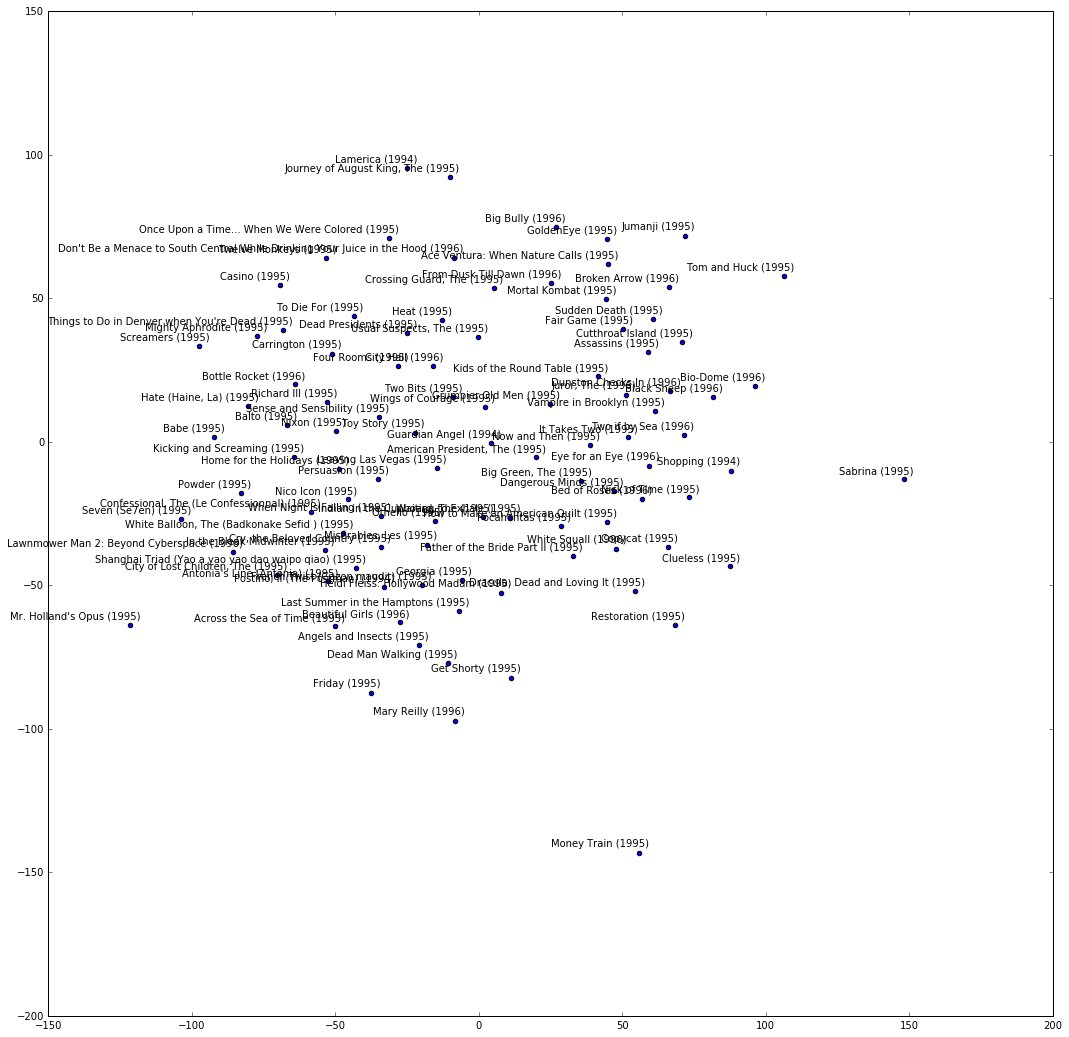

In [163]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

tsne = TSNE(perplexity=15, n_components=2, init="pca", n_iter=5000)
plot_only = 100
coords = tsne.fit_transform(embeddings[:plot_only, :])

plt.figure(figsize=(18, 18))
labels = [movies.iloc[i].Title.decode("latin_1") for i in range(plot_only)]
for i, label in enumerate(labels):
    x, y = coords[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(10, 4),
                 textcoords="offset points",
                 ha="right",
                 va="bottom")

plt.show()